# Chapter 7 - Exercises

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.interpolate import BSpline
from scipy.special import expit
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [49]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
LDS_FILE = "lds_by_state.csv"
LAFFER_FILE = "Laffer.csv"
FOXES_FILE = "foxes.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## Easy

### 7E1

State the three motivating criteria that define information entropy.
Try to express each in your own words.

---

Information entropy is a function of probabilities $p=(p_i)$ such that the following hold.
1. It is continuous in the $p_i$.
2. Increasing the number of possible outcomes should increase the entropy. That is, if a possible outcome with probability $p_i$ is replaced by two outcomes whose probabilities sum to $p_i$ then the entropy should increase (strictly if the new outcomes have non-zero probability)
3. It is additive, in the sense that if we add a new *independent* random variable then then entropy of the joint distribution is the sum of the entropies of the marginal distributions.

### 7E2

Suppose a coin is weighted such that, when it is tosssed and lands on a table, it comes up heads 70% of the time.
What is the entropy of the coin.

---

In [5]:
def information_entropy(p_pred, p_true=None):
    """Cross-entropy. Reduces to entropy if p_true=None."""
    if p_true is None:
        p_true = p_pred

    p_pred = np.array(p_pred)
    p_true = np.array(p_true)

    return -np.sum(p_true * np.log(p_pred))

In [6]:
information_entropy([0.3, 0.7])

0.6108643020548935

### 7E3

suppose a four-sided die is loaded such that, when tossed onto a table, it shows "1" 20%, "2" 25%, "3" 25%, and "4" 30% of the time.
What is the entropy of the die?

---

In [7]:
information_entropy([0.2, 0.25, 0.25, 0.3])

1.3762266043445461

### 7E4

Suppose another four-sided die is loaded such that it never shows "4".
The other three sides show equally often.
What is the entropy of this die.
---

We don't need to account for events with probability zero, so the entropy is

In [8]:
information_entropy([1 / 3, 1 / 3, 1 / 3])

1.0986122886681096

## Medium

### 7M1

Write down and compare the definitions of AIC and WAIC.
Which of these criteria is most generic?
Which assumptions are required to transform the more general criterion into a less general one?

---

The criteria are defined by

\begin{align}
    \text{AIC} &= D_{\text{train}} + 2p, & \text{WAIC} &= D_{\text{train}} + 2\sum_i \text{Var}(\ln(\text{Pr}(y_i | \Theta))),
\end{align}

where $D_{\text{train}}$ is the devaince over the training set, $p$ is the number of parameters, $y_i$ are the observations, and $\Theta$ is the set of parameters.
The difference between the definitions is in the correction term - the expression for WAIC is a more accurate estimate of the over-fitting bias in the training deviance.

The WAIC is the most generic (hence WI = Widely Applicable).

I don't quite understand the last part of the question, but I think it's asking under what assumptions do these definitions agree.
We need to assume
1. Flat priors
2. Multivariate normal posteriors
3. The sample size is much greater than the number of parameters

### 7M2

Explain the difference between model *selection* and model *comparison*.
What information is lost under model selection?

---

Model selection means building multiple models and selecting which to use based on some estimate of out-of-sample predictive accuracy, such as WAIC or PSIS.
Essentially it is using WAIC or PSIS to identify a 'best' model.
Model comparison means using WAIC or PSIS to understand how different variables (and modelling assumptions) influence predictions and predictive accuracy.

Under model selection we lose the context of the models considered, and their relative scores.
We also disregard casual questions when we focus solely on predictive accuracy.

### 7M3

When comparing models with an information criterion, why must all models be fit to exactly the same observations?
What would happen to the information criterion values, if the models were fit to different numbers of observations?
Perform some experiments, if you are not sure.

---

The information criteria defined are explicitly dependent on the observations.
In particular, they are additive - the value for a group of observations is the sum of the individual values.
This means that expanding a sample of observations can only increase the value of the information criterion.
This can be solved by taking an average; that is, dividing the number of information criterion by the number of samples.
This should theoretically make the information criterion independent of the observations for a sufficiently large sample, but in practice particular observations may have a large effect on the criterion and so it's important that these be included for all models being compared.

### 7M4

What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior becomes more concentrated?
Why?
Perform some experiments, if you are not sure.

---

With a completely flat prior all observations are equally plausible.
Thus the log-likelihood of the observations is relatively flat (even under the posterior distributions).
As the prior becomes more opinionated, there is more variance in the likelihood of different observations and so the number of effective parameters in WAIC decreases.
Since importance sampling involves weighting observations by the reciprocals of their (posterior) likelihoods, again higher variance in the likelihoods of different observations means that we give (relatively) more weight to lower likelihoods which decreases PSIS.

This also makes intuitive sense; the number of effective parameters quantifies how the extent to which the model is overfit and so tighter priors should decrease the value.

### 7M5

Provide an informal explanation of why informative priors reduce overfitting.

---

Informative priors reduce the extent to which individual observations influence the likelihood.
For example, if I have an extremely uninformative prior on human height and then measure the heights of a few basketball players, it will lead to a strong belief that 2 metres is an normal height, and so my model will be bad at predicting the heights of the general population.
However if I use an informative prior my model won't be so affected by these extreme values and will do better in general.

### 7M6

Provide an informal explanation of why overly informative priors result in underfitting.

----

Overly informative priors dominate the observed data meaning that your posterior is relatively similar to the prior.
This means that the model doesn't learn much from the data, including the true (non-stochastic) patterns, and so will generalise less well to unseen data.

## Hard

### 7H1

In 2007, *The Wall Street Journal* published an editorial ("We're Number One, Alas") with a graph of corporate tax rates in 29 countries plotted against tax revenue.
A badly fit curve was drawn in, seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue.
I want you to actually fit a curve to these data, found in `data(Laffer)`.
Consider models that use tax rate to predict tax revenue.
Compare, using WAIC or PSIS, a straight-line model to any curved models you like.
What do you conclude about the relationship between tax rate and tax revenue?

---

In [9]:
# load data
laffer = load_data(LAFFER_FILE, delimiter=";")


def normalise(data):
    return (data - data.mean()) / data.std()


# normalise variables
laffer["tax_rate_norm"] = normalise(laffer["tax_rate"])
laffer["tax_revenue_norm"] = normalise(laffer["tax_revenue"])

First try a linear model.

In [10]:
coords = {
    "obs_id": laffer.index,
}
with pm.Model(coords_mutable=coords) as m_7h1a:
    # data
    tax_rate = pm.MutableData("tax_rate", laffer.tax_rate, dims="obs_id")
    tax_rate_norm = pm.Deterministic(
        "tax_rate_norm",
        (tax_rate - laffer.tax_rate.mean()) / laffer.tax_rate.std(),
        dims="obs_id",
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=2)  # think about this
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic("mu_norm", alpha + beta * tax_rate_norm, dims="obs_id")

    # likelihood
    tax_revenue_norm = pm.Normal(
        "tax_revenue_norm",
        mu=mu_norm,
        sigma=sigma,
        observed=laffer.tax_revenue_norm,
        dims="obs_id",
    )

    # push-forward
    mu = pm.Deterministic(
        "mu",
        mu_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )
    tax_revenue = pm.Deterministic(
        "tax_revenue",
        tax_revenue_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )

    # sample prior
    prior_trace_7h1a = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, sigma, tax_revenue_norm]


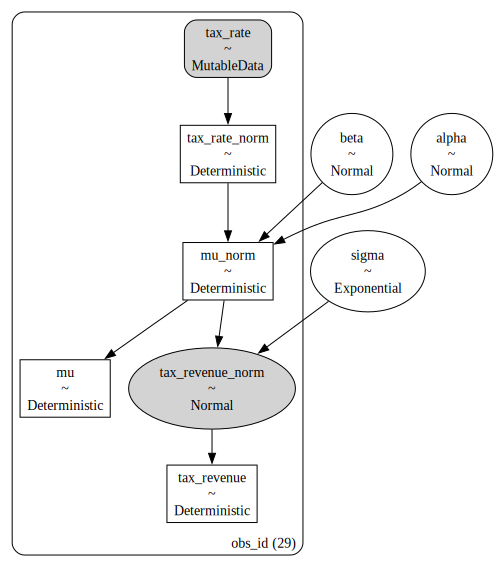

In [11]:
m_7h1a.to_graphviz()

Let's do some prior predictive checks - sample some regression lines

In [12]:
def plot_laffer_linear_model_sample_lines(
    trace, laffer, n_lines=50, group="prior", normalised=False, ax=None
):
    alpha_sample = trace[group].alpha.isel(chain=0, draw=range(n_lines))
    beta_sample = trace[group].beta.isel(chain=0, draw=range(n_lines))

    x = np.linspace(laffer.tax_rate.min(), laffer.tax_rate.max(), 1000)
    x_norm = (x - laffer.tax_rate.mean()) / laffer.tax_rate.std()

    alpha_samplev, x_normv = np.meshgrid(alpha_sample, x_norm)
    beta_samplev, _ = np.meshgrid(beta_sample, x_norm)

    y_normv = alpha_samplev + beta_samplev * x_normv
    yv = y_normv * laffer.tax_revenue.std() + laffer.tax_revenue.mean()

    if not ax:
        fig, ax = plt.subplots(figsize=(8, 6))

    if normalised:
        ax.plot(x_normv, y_normv, color="k", alpha=0.3)
        ax.set(
            xlabel="Tax rate (norm.)",
            ylabel="Tax revenue (norm.)",
        )
    else:
        _, xv = np.meshgrid(alpha_sample, x)
        ax.plot(xv, yv, color="k", alpha=0.3)
        ax.set(
            xlabel="Tax rate",
            ylabel="Tax revenue",
        )

    ax.set(title=f"Sample regression lines ({group})")

    return ax

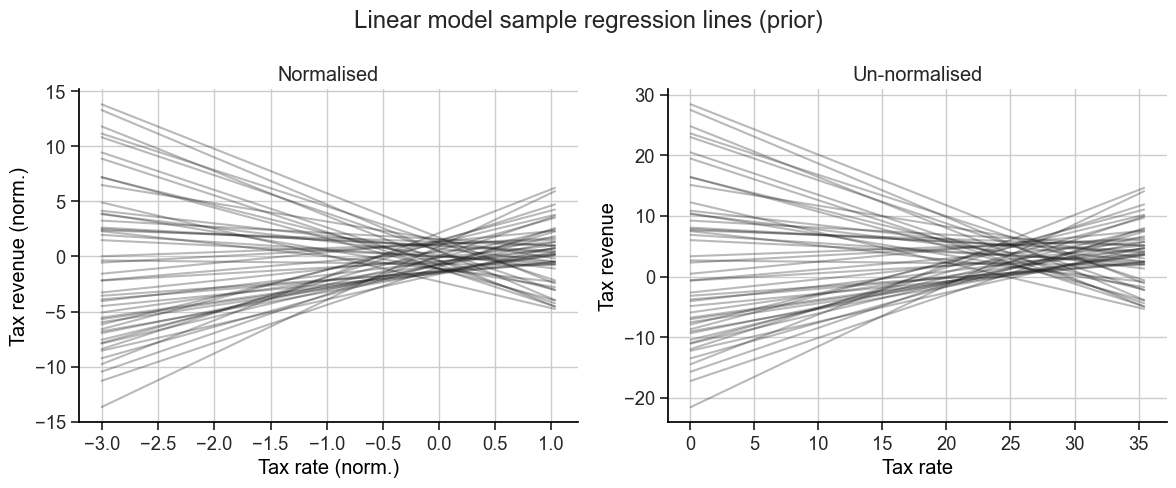

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

plot_laffer_linear_model_sample_lines(
    prior_trace_7h1a, laffer, normalised=True, ax=axs[0]
)
plot_laffer_linear_model_sample_lines(
    prior_trace_7h1a, laffer, normalised=False, ax=axs[1]
)

axs[0].set(title="Normalised")
axs[1].set(title="Un-normalised")

fig.suptitle("Linear model sample regression lines (prior)")
fig.tight_layout();

I don't love these priors - they seem quite wide and the tax revenue should be strictly positive, but it's good enough.

Now let's do a quadratic model.

In [14]:
coords = {
    "obs_id": laffer.index,
}
with pm.Model(coords_mutable=coords) as m_7h1b:
    # data
    tax_rate = pm.MutableData("tax_rate", laffer.tax_rate, dims="obs_id")
    tax_rate_norm = pm.Deterministic(
        "tax_rate_norm",
        (tax_rate - laffer.tax_rate.mean()) / laffer.tax_rate.std(),
        dims="obs_id",
    )
    tax_rate_norm_sq = pm.Deterministic(
        "tax_rate_norm_sq", tax_rate_norm**2, dims="obs_id"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=0.5)  # think about this
    beta2 = pm.Normal("beta2", mu=0, sigma=1)  # think about this
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm",
        alpha + beta1 * tax_rate_norm + beta2 * tax_rate_norm_sq,
        dims="obs_id",
    )

    # likelihood
    tax_revenue_norm = pm.Normal(
        "tax_revenue_norm",
        mu=mu_norm,
        sigma=sigma,
        observed=laffer.tax_revenue_norm,
        dims="obs_id",
    )

    # push-forward
    mu = pm.Deterministic(
        "mu",
        mu_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )
    tax_revenue = pm.Deterministic(
        "tax_revenue",
        tax_revenue_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )

    # sample prior
    prior_trace_7h1b = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta1, beta2, sigma, tax_revenue_norm]


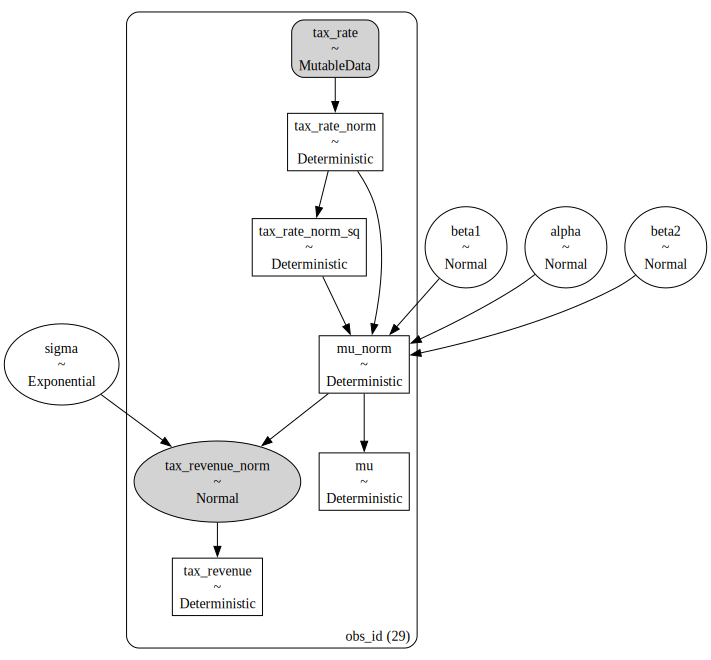

In [15]:
m_7h1b.to_graphviz()

In [16]:
def plot_laffer_quadratic_model_sample_lines(
    trace, laffer, n_lines=50, group="prior", normalised=False, ax=None
):
    alpha_sample = trace[group].alpha.isel(chain=0, draw=range(n_lines))
    beta1_sample = trace[group].beta1.isel(chain=0, draw=range(n_lines))
    beta2_sample = trace[group].beta2.isel(chain=0, draw=range(n_lines))

    x = np.linspace(laffer.tax_rate.min(), laffer.tax_rate.max(), 1000)
    x_norm = (x - laffer.tax_rate.mean()) / laffer.tax_rate.std()

    alpha_samplev, x_normv = np.meshgrid(alpha_sample, x_norm)
    beta1_samplev, _ = np.meshgrid(beta1_sample, x_norm)
    beta2_samplev, _ = np.meshgrid(beta2_sample, x_norm)

    y_normv = alpha_samplev + beta1_samplev * x_normv + beta2_samplev * x_normv**2
    yv = y_normv * laffer.tax_revenue.std() + laffer.tax_revenue.mean()

    if not ax:
        fig, ax = plt.subplots(figsize=(8, 6))

    if normalised:
        ax.plot(x_normv, y_normv, color="k", alpha=0.3)
        ax.set(
            xlabel="Tax rate (norm.)",
            ylabel="Tax revenue (norm.)",
        )
    else:
        _, xv = np.meshgrid(alpha_sample, x)
        ax.plot(xv, yv, color="k", alpha=0.3)
        ax.set(
            xlabel="Tax rate",
            ylabel="Tax revenue",
        )

    ax.set(title=f"Sample regression lines ({group})")

    return ax

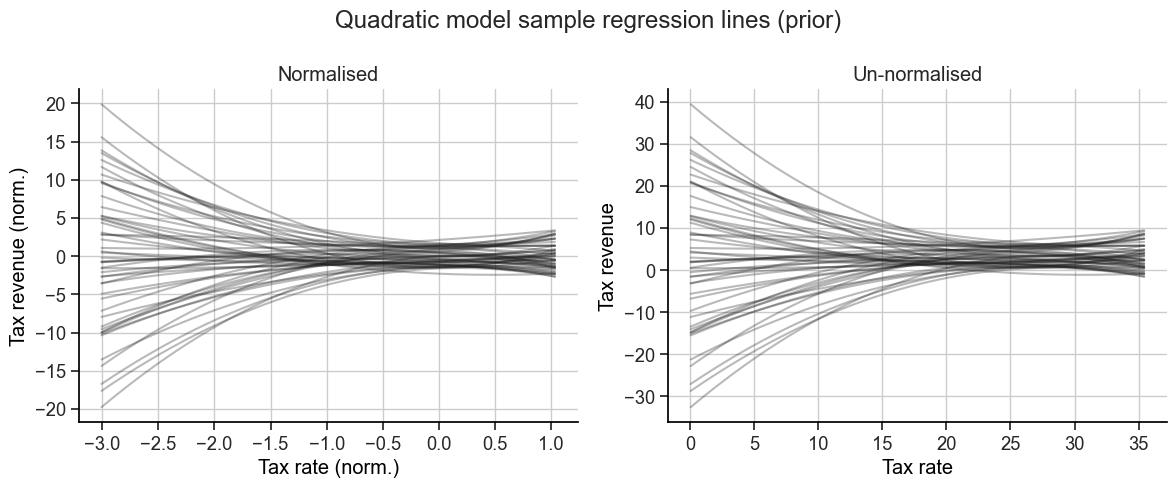

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

plot_laffer_quadratic_model_sample_lines(
    prior_trace_7h1b, laffer, normalised=True, ax=axs[0]
)
plot_laffer_quadratic_model_sample_lines(
    prior_trace_7h1b, laffer, normalised=False, ax=axs[1]
)

axs[0].set(title="Normalised")
axs[1].set(title="Un-normalised")

fig.suptitle("Quadratic model sample regression lines (prior)")
fig.tight_layout();

Again, these aren't amazing but they'll do.

Now let's fit the models.

In [18]:
with m_7h1a:
    trace_7h1a = pm.sample(random_seed=RANDOM_SEED)

with m_7h1b:
    trace_7h1b = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Plot some posterior lines against the actual data.

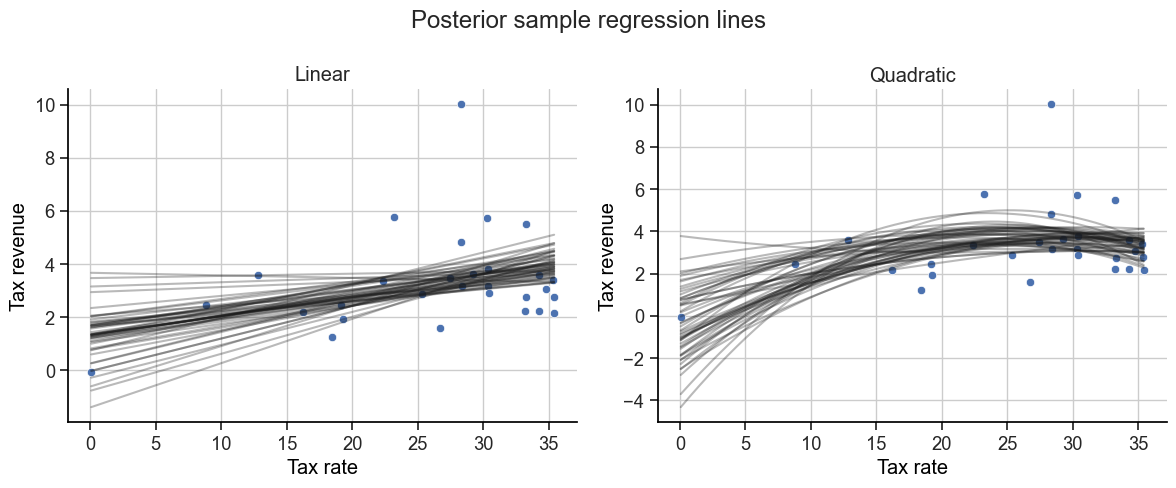

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[0],
)
sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[1],
)

plot_laffer_linear_model_sample_lines(
    trace_7h1a, laffer, group="posterior", normalised=False, ax=axs[0]
)
plot_laffer_quadratic_model_sample_lines(
    trace_7h1b, laffer, group="posterior", normalised=False, ax=axs[1]
)

axs[0].set(title="Linear")
axs[1].set(title="Quadratic")

fig.suptitle("Posterior sample regression lines")
fig.tight_layout();

Interesting.
There's a lot of uncertainty in the quadratic posteriors.
It might be clearer if we plot HDIs.

In [20]:
def plot_laffer_posterior_hdi(model, trace, laffer, hdi_prob=0.89, ax=None):
    tax_rate_vals = np.linspace(
        laffer.tax_rate.min(),
        laffer.tax_rate.max(),
        1000,
    )
    with model:
        pm.set_data(
            {
                "tax_rate": tax_rate_vals,
            },
            coords={
                "obs_id": range(len(tax_rate_vals)),
            },
        )
        pred_trace = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "tax_revenue"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    mu_mean = pred_trace.predictions.mu.mean(dim=["chain", "draw"])
    ax.plot(tax_rate_vals, mu_mean, color="k")

    mu_hdi = az.hdi(pred_trace.predictions.mu, hdi_prob=hdi_prob).mu
    ax.fill_between(
        tax_rate_vals,
        mu_hdi.sel(hdi="lower"),
        mu_hdi.sel(hdi="higher"),
        color="k",
        alpha=0.3,
    )

    tax_revenue_hdi = az.hdi(
        pred_trace.predictions.tax_revenue, hdi_prob=hdi_prob
    ).tax_revenue
    ax.fill_between(
        tax_rate_vals,
        tax_revenue_hdi.sel(hdi="lower"),
        tax_revenue_hdi.sel(hdi="higher"),
        color="k",
        alpha=0.1,
    )

    ax.set(
        xlabel="Tax rate",
        ylabel="Tax revenue",
        title="Posterior HDIs",
    )

    return ax

Sampling: [tax_revenue_norm]


Sampling: [tax_revenue_norm]


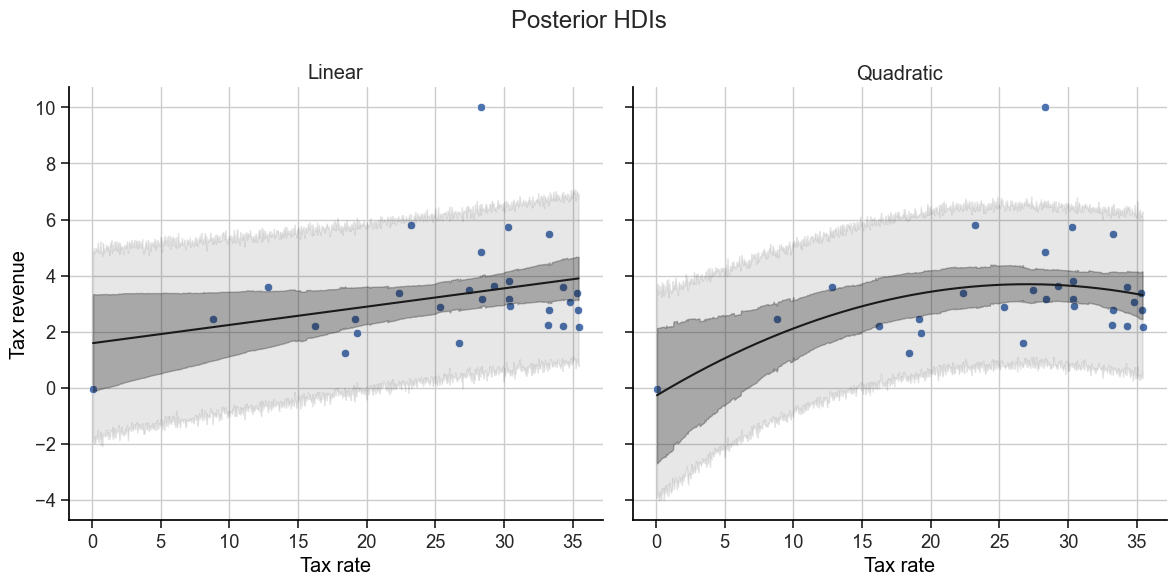

In [21]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[0],
)
sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[1],
)

plot_laffer_posterior_hdi(m_7h1a, trace_7h1a, laffer, ax=axs[0])
plot_laffer_posterior_hdi(m_7h1b, trace_7h1b, laffer, ax=axs[1])

axs[0].set(title="Linear")
axs[1].set(title="Quadratic")

fig.suptitle("Posterior HDIs")
fig.tight_layout();

They look vaguely reasonable, with the caveat that they don't recognise that revenue can't be negative.
The quadratic fit doesn't look much better - it seems like it's doing a lot of work just to fit the point at the origin.
Come to think of it the line should definitely fit through there.
If I were to redo this I wouldn't standardise the data and would remove the intercept to force the curves to go through the origin.

Now let's look at the information criteria.

In [22]:
with m_7h1a:
    pm.set_data(
        {"tax_rate": laffer.tax_rate},
        coords={"obs_id": laffer.index},
    )
    pm.compute_log_likelihood(trace_7h1a)

with m_7h1b:
    pm.set_data(
        {"tax_rate": laffer.tax_rate},
        coords={"obs_id": laffer.index},
    )
    pm.compute_log_likelihood(trace_7h1b)

In [23]:
az.compare(
    {
        "linear": trace_7h1a,
        "quadratic": trace_7h1b,
    },
    ic="loo",
    scale="deviance",
)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
quadratic,0,85.611587,5.271678,0.000000,1.000000e+00,18.182984,0.000000,True,deviance
linear,1,88.800078,5.693690,3.188491,2.220446e-16,19.390178,2.103109,True,deviance


The quadratic model has lower deviance, but the standard error is about 6 times the difference so this doesn't seem very reliable as an estimate of the difference.

For confirmation let's check WAIC

In [24]:
az.compare(
    {
        "linear": trace_7h1a,
        "quadratic": trace_7h1b,
    },
    ic="waic",
    scale="deviance",
)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
quadratic,0,85.371248,5.151509,0.00000,1.0,18.093501,0.000000,True,deviance
linear,1,87.475488,5.031395,2.10424,0.0,18.167879,1.745959,True,deviance


This gives a similar conclusion.

In summary a quadratic model has a better out-of-sample fit, but this improvement isn't very significant when compared with the standard error.

### 7H2

In the `Laffer` data, there is one country with a high tax revenue that is an outlier.
User PSIS and WAIC to measure the importance of this outlier in the modles you fit in the previous problem.
Then use robust regression with a Student's t distribution to revisit the cure fitting problem.
How much does a curved relationship depend upon the outlier point?

---

Let's get the individual Pareto k values and WAIC values and plot them for the two models.

In [25]:
psis_7h1a = az.loo(trace_7h1a, scale="deviance", pointwise=True)
waic_7h1a = az.waic(trace_7h1a, scale="deviance", pointwise=True)

psis_7h1b = az.loo(trace_7h1b, scale="deviance", pointwise=True)
waic_7h1b = az.waic(trace_7h1b, scale="deviance", pointwise=True)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 fo

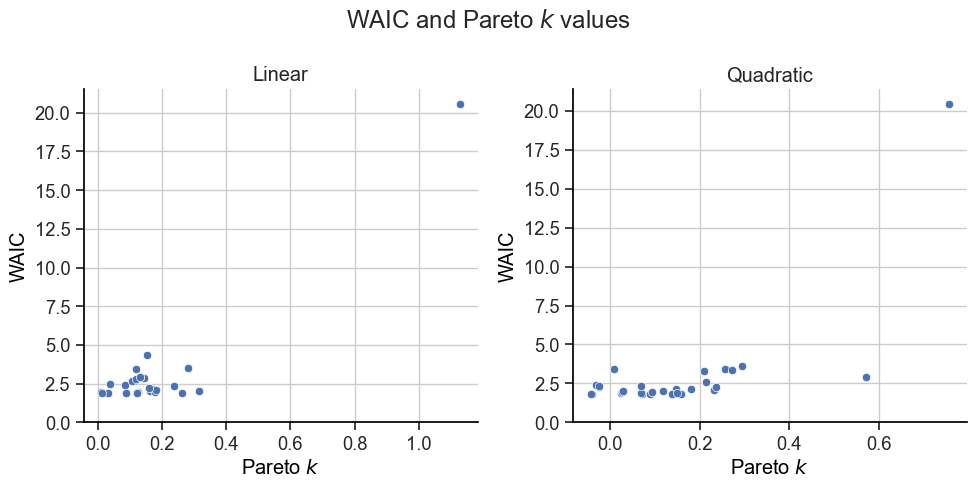

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

sns.scatterplot(
    x=psis_7h1a.pareto_k,
    y=waic_7h1a.waic_i,
    ax=axs[0],
)
sns.scatterplot(
    x=psis_7h1b.pareto_k,
    y=waic_7h1b.waic_i,
    ax=axs[1],
)

for ax in axs:
    ax.set_ylim(ymin=0)
    ax.set(
        xlabel="Pareto $k$",
        ylabel="WAIC",
    )

axs[0].set(title="Linear")
axs[1].set(title="Quadratic")

fig.suptitle("WAIC and Pareto $k$ values")
fig.tight_layout();

As expected, this has a lot of impact on the two models - particularly the linear model.
Note that there is another influential point for the quadratic model.
I expected that this is the point at the origin (presumably Dubai).

First let's just check that this is the top right point.

In [27]:
laffer.loc[psis_7h1a.pareto_k.argmax().item()]

tax_rate            28.320000
tax_revenue         10.020000
tax_rate_norm        0.221387
tax_revenue_norm     3.696024
Name: 11, dtype: float64

Yup.

Now let's try robust regression using a Student's t distribution.

In [28]:
coords = {
    "obs_id": laffer.index,
}
with pm.Model(coords_mutable=coords) as m_7h1c:
    # data
    tax_rate = pm.MutableData("tax_rate", laffer.tax_rate, dims="obs_id")
    tax_rate_norm = pm.Deterministic(
        "tax_rate_norm",
        (tax_rate - laffer.tax_rate.mean()) / laffer.tax_rate.std(),
        dims="obs_id",
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=2)  # think about this
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic("mu_norm", alpha + beta * tax_rate_norm, dims="obs_id")

    # likelihood
    tax_revenue_norm = pm.StudentT(
        "tax_revenue_norm",
        nu=2,
        mu=mu_norm,
        sigma=sigma,
        observed=laffer.tax_revenue_norm,
        dims="obs_id",
    )

    # push-forward
    mu = pm.Deterministic(
        "mu",
        mu_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )
    tax_revenue = pm.Deterministic(
        "tax_revenue",
        tax_revenue_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )

    # sample prior
    trace_7h1c = pm.sample(
        random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )


with pm.Model(coords_mutable=coords) as m_7h1d:
    # data
    tax_rate = pm.MutableData("tax_rate", laffer.tax_rate, dims="obs_id")
    tax_rate_norm = pm.Deterministic(
        "tax_rate_norm",
        (tax_rate - laffer.tax_rate.mean()) / laffer.tax_rate.std(),
        dims="obs_id",
    )
    tax_rate_norm_sq = pm.Deterministic(
        "tax_rate_norm_sq", tax_rate_norm**2, dims="obs_id"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=0.5)  # think about this
    beta2 = pm.Normal("beta2", mu=0, sigma=1)  # think about this
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm",
        alpha + beta1 * tax_rate_norm + beta2 * tax_rate_norm_sq,
        dims="obs_id",
    )

    # likelihood
    tax_revenue_norm = pm.StudentT(
        "tax_revenue_norm",
        nu=2,
        mu=mu_norm,
        sigma=sigma,
        observed=laffer.tax_revenue_norm,
        dims="obs_id",
    )

    # push-forward
    mu = pm.Deterministic(
        "mu",
        mu_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )
    tax_revenue = pm.Deterministic(
        "tax_revenue",
        tax_revenue_norm * laffer.tax_revenue.std() + laffer.tax_revenue.mean(),
        dims="obs_id",
    )

    # sample prior
    trace_7h1d = pm.sample(
        random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


How does this affect the posterior regression lines?

Sampling: [tax_revenue_norm]


Sampling: [tax_revenue_norm]


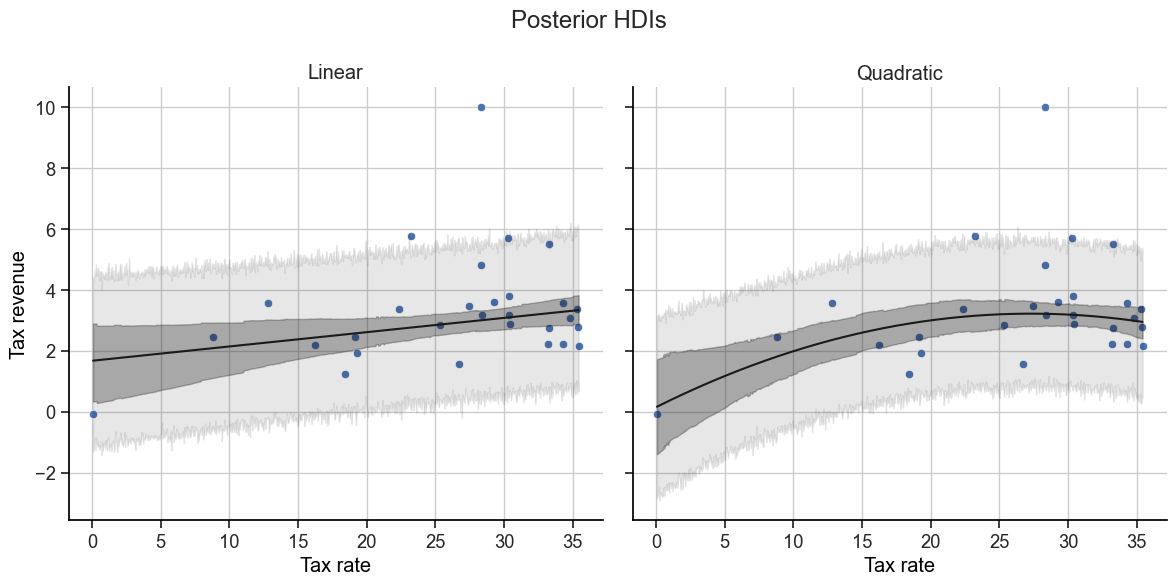

In [29]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[0],
)
sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[1],
)

plot_laffer_posterior_hdi(m_7h1c, trace_7h1c, laffer, ax=axs[0])
plot_laffer_posterior_hdi(m_7h1d, trace_7h1d, laffer, ax=axs[1])

axs[0].set(title="Linear")
axs[1].set(title="Quadratic")

fig.suptitle("Posterior HDIs")
fig.tight_layout();

They don't look wildly different to the eye.
What about the PSIS values?

In [30]:
az.compare(
    {
        "linear": trace_7h1a,
        "quadratic": trace_7h1b,
        "robust_linear": trace_7h1c,
        "robust_quadratic": trace_7h1d,
    },
    ic="loo",
    scale="deviance",
)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
robust_quadratic,0,71.640958,3.918296,0.000000,0.873594,12.457699,0.000000,False,deviance
robust_linear,1,73.831630,3.339902,2.190672,0.000000,12.380088,3.091523,False,deviance
quadratic,2,85.611587,5.271678,13.970629,0.126406,18.182984,10.719203,True,deviance
linear,3,88.800078,5.693690,17.159120,0.000000,19.390178,11.900151,True,deviance


Robust regression seems to have improved our predictive accuracy, to a point where it now seems significant when compared with the standard errors.
And we no longer get warnings for influential points.

Let's compare them on plots.

In [31]:
psis_7h1c = az.loo(trace_7h1c, scale="deviance", pointwise=True)
waic_7h1c = az.waic(trace_7h1c, scale="deviance", pointwise=True)

psis_7h1d = az.loo(trace_7h1d, scale="deviance", pointwise=True)
waic_7h1d = az.waic(trace_7h1d, scale="deviance", pointwise=True)

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


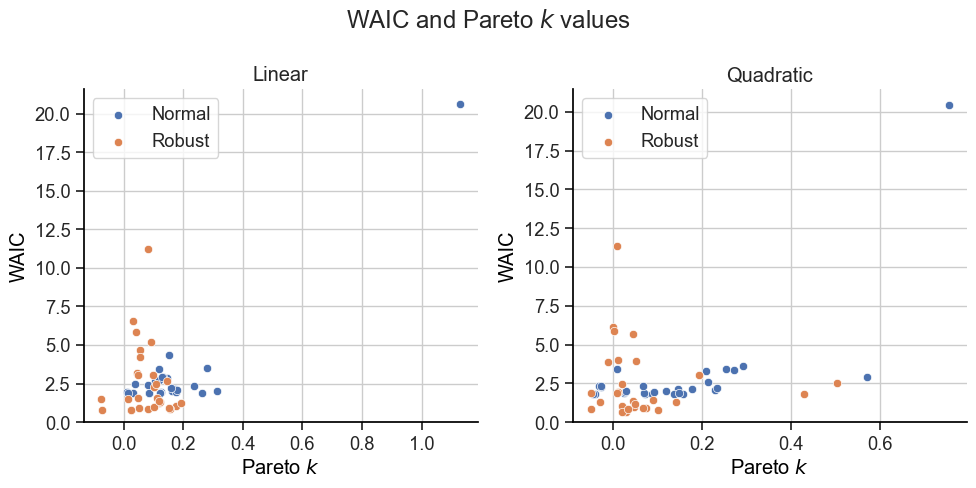

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

sns.scatterplot(
    x=psis_7h1a.pareto_k,
    y=waic_7h1a.waic_i,
    color=colors[0],
    label="Normal",
    ax=axs[0],
)
sns.scatterplot(
    x=psis_7h1c.pareto_k,
    y=waic_7h1c.waic_i,
    color=colors[1],
    label="Robust",
    ax=axs[0],
)

sns.scatterplot(
    x=psis_7h1b.pareto_k,
    y=waic_7h1b.waic_i,
    color=colors[0],
    label="Normal",
    ax=axs[1],
)
sns.scatterplot(
    x=psis_7h1d.pareto_k,
    y=waic_7h1d.waic_i,
    color=colors[1],
    label="Robust",
    ax=axs[1],
)

for ax in axs:
    ax.set_ylim(ymin=0)
    ax.set(
        xlabel="Pareto $k$",
        ylabel="WAIC",
    )
    ax.legend()

axs[0].set(title="Linear")
axs[1].set(title="Quadratic")

fig.suptitle("WAIC and Pareto $k$ values")
fig.tight_layout();

This is massive improvement.
Although, interestingly the point is still particularly influential from a WAIC perspective.
But for PSIS at least it no longer seems that the fit depends so much on that point.

We can double check this by manually refitting without the point.

In [33]:
outlier_idx = 11
laffer_no_outlier = laffer.drop(index=outlier_idx)

coords = {
    "obs_id": laffer_no_outlier.index,
}
with pm.Model(coords_mutable=coords) as m_7h1e:
    # data
    tax_rate = pm.MutableData("tax_rate", laffer_no_outlier.tax_rate, dims="obs_id")
    tax_rate_norm = pm.Deterministic(
        "tax_rate_norm",
        (tax_rate - laffer_no_outlier.tax_rate.mean())
        / laffer_no_outlier.tax_rate.std(),
        dims="obs_id",
    )
    tax_rate_norm_sq = pm.Deterministic(
        "tax_rate_norm_sq", tax_rate_norm**2, dims="obs_id"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=0.5)  # think about this
    beta2 = pm.Normal("beta2", mu=0, sigma=1)  # think about this
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu_norm = pm.Deterministic(
        "mu_norm",
        alpha + beta1 * tax_rate_norm + beta2 * tax_rate_norm_sq,
        dims="obs_id",
    )

    # likelihood
    tax_revenue_norm = pm.StudentT(
        "tax_revenue_norm",
        nu=2,
        mu=mu_norm,
        sigma=sigma,
        observed=laffer_no_outlier.tax_revenue_norm,
        dims="obs_id",
    )

    # push-forward
    mu = pm.Deterministic(
        "mu",
        mu_norm * laffer_no_outlier.tax_revenue.std()
        + laffer_no_outlier.tax_revenue.mean(),
        dims="obs_id",
    )
    tax_revenue = pm.Deterministic(
        "tax_revenue",
        tax_revenue_norm * laffer_no_outlier.tax_revenue.std()
        + laffer_no_outlier.tax_revenue.mean(),
        dims="obs_id",
    )

    # sample prior
    trace_7h1e = pm.sample(
        random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [tax_revenue_norm]


Sampling: [tax_revenue_norm]


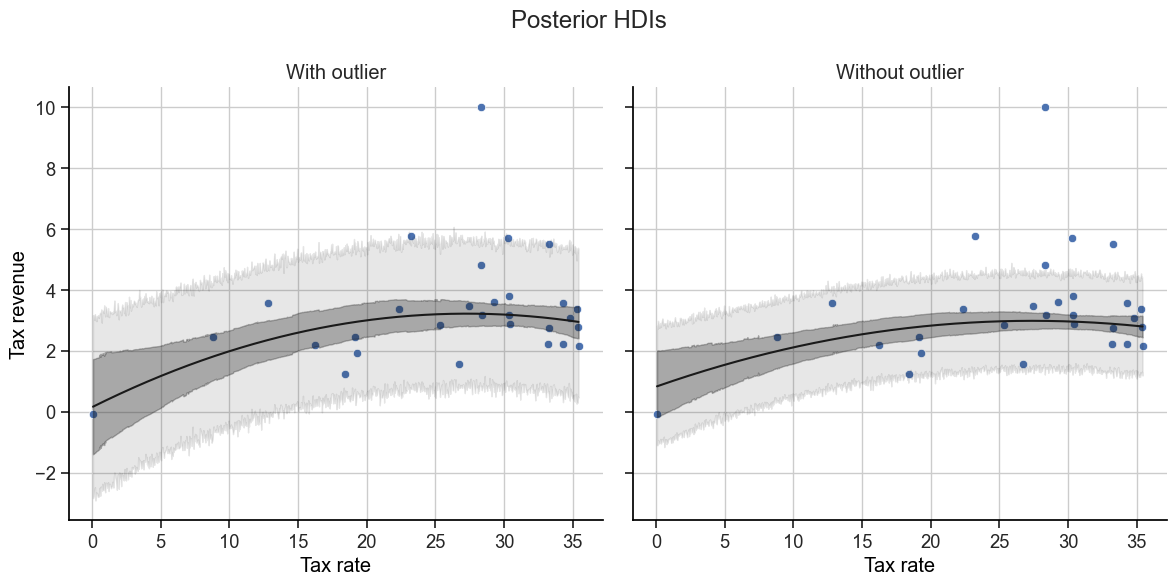

In [34]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[0],
)
sns.scatterplot(
    laffer,
    x="tax_rate",
    y="tax_revenue",
    ax=axs[1],
)

plot_laffer_posterior_hdi(m_7h1d, trace_7h1d, laffer, ax=axs[0])
plot_laffer_posterior_hdi(m_7h1e, trace_7h1e, laffer, ax=axs[1])

axs[0].set(title="With outlier")
axs[1].set(title="Without outlier")

fig.suptitle("Posterior HDIs")
fig.tight_layout();

It doesn't seem like there's much difference except a lower variance in the second plot.
This is even clearer looking at the posterior distributions directly.

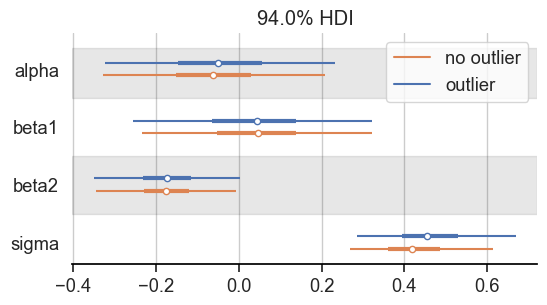

In [35]:
fig, ax = plt.subplots(figsize=(6, 3))
az.plot_forest(
    [trace_7h1d, trace_7h1e],
    model_names=["outlier", "no outlier"],
    var_names=[
        "alpha",
        "beta1",
        "beta2",
        "sigma",
    ],
    combined=True,
    ax=ax,
);

There is very little difference, except for slightly lower values for sigma when the outlier is removed.

### 7H3

Consider three fictional Polynesian islands.
On each there is a Royal Ornithologist charged by the king with surveying the bird population.
They have each found the following proportions of 6 important bird species:

In [36]:
birds = pd.DataFrame(
    index=pd.Index([1, 2, 3], name="island"),
    data={
        "a": [0.2, 0.8, 0.05],
        "b": [0.2, 0.1, 0.15],
        "c": [0.2, 0.05, 0.7],
        "d": [0.2, 0.025, 0.05],
        "e": [0.2, 0.025, 0.05],
    },
)
birds.columns.name = "species"
birds

species,a,b,c,d,e
island,,,,,
1,0.20,0.20,0.20,0.200,0.200
2,0.80,0.10,0.05,0.025,0.025
3,0.05,0.15,0.70,0.050,0.050


Notice that each row sums to 1, all the birds.
This problem has two parts.
It is not computationally complicated.
But it is conceptually tricky.
First, compute the entropy of each island's bird distribution.
Interpret these entropy values.
Second, use each island's bird distribution to predict the other two.
This means to compute the KL divergence of each island from the others, treating each island as if it were a statistical model of the other islands.
You should end up with 6 different KL divergence values.
Which island predicts the others best?
Why?

---

The entropy for each island:

In [37]:
birds.apply(information_entropy, axis=1)

island
1    1.609438
2    0.743004
3    0.983600
dtype: float64

The information entropy measures the amount of uncertainty when trying to predict the bird species knowing the propbabilities.
So, the first island will have the greatest surprise in outcomes, then the third island, then the second.
This fits with intuition: the first island has equal probabilities so knowing those probabilities gives us the least information about the outcomes.

Now the KL divergence between islands.

In [38]:
def kl_divergence(p_pred, p_true):
    return information_entropy(p_pred, p_true) - information_entropy(p_true)

In [39]:
birds_kl = [
    [kl_divergence(p_pred, p_true) for _, p_true in birds.iterrows()]
    for _, p_pred in birds.iterrows()
]
birds_kl = pd.DataFrame(
    index=birds.index.rename("island_pred"),
    columns=birds.index.rename("island_true"),
    data=birds_kl,
)
birds_kl

island_true,1,2,3
island_pred,,,
1,0.000000,0.866434,0.625838
2,0.970406,0.000000,1.838845
3,0.638760,2.010914,0.000000


Does this fit with our intuition?
This suggests that we would be particularly surprised if we used the probabilities of islands 2 and 3 to predict each other's outcomes.
That tracks; using the probabilities of island 2 we would expect *a* to be the most likely outcome, but for island 3 this only has a true probability of 5%.

Overall, island 1 predicts the others best.
This is because is the other two islands have extreme values and are very different.
This makes them opinionated and particularly bad at predicting each other.
This links to maximum entropy distributions in chapter 10; given no additional information, we should make predictions using the distribution with the greatest entropy.
In this case that means having equal probabilities of each outcome.

### 7H4

Recall the marriage, age, and happiness collider bias example from Chapter 6.
Run models `m6.9` and `m6.10` again (page 178).
Conpare these two models using WAIC (or PSIS, they will product identical results).
Which model is expected to make better predictions?
Which model provides the correct causal inference about the influence of age on happiness?
Can you explain why the answers to these two questions disagree?

----

First lets re-generate the data.

In [40]:
def simulate_marriages(
    n_years, random_seed, p_marriage_intercept=-4, p_marriage_slope=1
):
    # set random seed
    rng = np.random.default_rng(random_seed)

    # defaults
    BIRTHS_PER_YEAR = 20
    MIN_MARRIAGE_AGE = 18
    MAX_MARRIAGE_AGE = 65

    # function for probability of marriage from happiness
    def prob_marriage(
        happiness, intercept=p_marriage_intercept, slope=p_marriage_slope
    ):
        return expit(intercept + slope * happiness)

    # run simulation
    people = pd.DataFrame(columns=["age", "happiness", "married"])
    for year in range(n_years):
        n_people = people.shape[0]

        # simulate people aging
        if n_people > 0:
            people["age"] = people["age"] + 1

            marriable_mask = (people["married"] == 0) & people["age"].between(
                MIN_MARRIAGE_AGE, MAX_MARRIAGE_AGE
            )
            people["married"] = np.where(
                marriable_mask,
                rng.binomial(
                    n=1,
                    p=prob_marriage(people.happiness),
                    size=n_people,
                ),
                people["married"],
            )

        # add new people
        new_people = pd.DataFrame(
            {
                "age": np.ones(BIRTHS_PER_YEAR),
                "happiness": rng.uniform(low=-2, high=2, size=BIRTHS_PER_YEAR),
                "married": np.zeros(BIRTHS_PER_YEAR),
            }
        )
        people = pd.concat([new_people, people], axis=0)

        # send people to spain
        people = people.loc[people["age"] <= MAX_MARRIAGE_AGE, :]

    return people

In [41]:
# run simulation
people = simulate_marriages(1_000, random_seed=RANDOM_SEED)

# restrict to adults
adults = people.loc[people["age"] >= 18, :].copy()
adults = adults.reset_index(drop=True)

# scale age
adults["age_scaled"] = (adults["age"] - 18) / (65 - 18)

Now let's run the models

In [42]:
# create indicator variable
adults["married_idx"], married_vals = pd.factorize(adults["married"])

coords = {
    "obs_id": adults.index,
    "married": married_vals,
}
with pm.Model(coords_mutable=coords) as m6_9:
    # data
    age_scaled = pm.MutableData("age_scaled", adults.age_scaled, dims="obs_id")
    married_idx = pm.MutableData("married_idx", adults.married_idx, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="married")
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha[married_idx] + beta_a * age_scaled, dims="obs_id")

    # likelihood
    happiness = pm.Normal(
        "happiness", mu=mu, sigma=sigma, observed=adults.happiness, dims="obs_id"
    )

    # sample
    trace_6_9 = pm.sample(
        random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )


with pm.Model(coords_mutable=coords) as m6_10:
    # data
    age_scaled = pm.MutableData("age_scaled", adults.age_scaled, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_a * age_scaled, dims="obs_id")

    # likelihood
    happiness = pm.Normal(
        "happiness", mu=mu, sigma=sigma, observed=adults.happiness, dims="obs_id"
    )

    # sample
    trace_6_10 = pm.sample(
        random_seed=RANDOM_SEED, idata_kwargs={"log_likelihood": True}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Let's compare these with WAIC.

In [43]:
az.compare(
    {
        "m6.9": trace_6_9,
        "m6.10": trace_6_10,
    },
    ic="waic",
    scale="deviance",
    seed=RANDOM_SEED,
)

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m6.9,0,2628.209296,3.762357,0.000000,0.962815,38.580972,0.000000,False,deviance
m6.10,1,2999.697457,2.396382,371.488161,0.037185,27.975713,35.708403,False,deviance


The first model is significantly better at making predictions.

Let's recall that the DAG is:

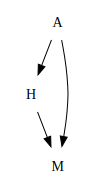

In [44]:
g = gr.Digraph("7h4", node_attr={"color": "white"})

g.node("H")
g.node("M")
g.node("A")

g.edge("A", "M")
g.edge("A", "H")
g.edge("H", "M")
g

and we are trying to estimate the effect of $A$ on $H$ (which we know is actually zero).

Model `m6.9` controls for $M$ and `m6.10` doesn't.
Since $M$ is a collider, we know that `m6.10` will provides a better causal estimate of the influence of $A$ on $H$.
We can check this as we know the correct answer:

In [45]:
az.summary(
    trace_6_9,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0.0],-0.23,0.06,-0.33,-0.13,0.0,0.0,1776.46,1833.67,1.0
alpha[1.0],1.16,0.08,1.03,1.29,0.0,0.0,1592.46,1810.45,1.0
beta_a,-0.71,0.11,-0.87,-0.52,0.0,0.0,1405.75,1556.00,1.0
sigma,0.95,0.02,0.92,0.98,0.0,0.0,2769.39,2577.72,1.0


In [46]:
az.summary(
    trace_6_10,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.07,-0.11,0.12,0.0,0.0,1932.99,2127.61,1.0
beta_a,-0.05,0.13,-0.24,0.16,0.0,0.0,1893.44,2114.63,1.0
sigma,1.15,0.03,1.11,1.19,0.0,0.0,2721.96,2761.91,1.0


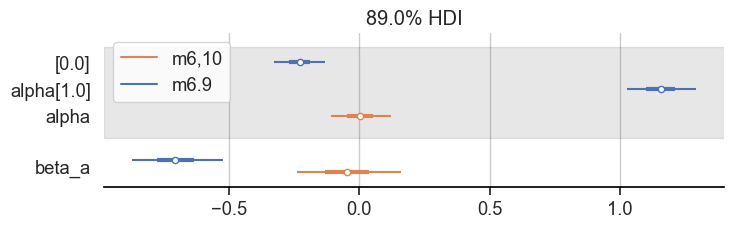

In [47]:
fig, ax = plt.subplots(figsize=(8, 2))
az.plot_forest(
    [trace_6_9, trace_6_10],
    model_names=["m6.9", "m6,10"],
    var_names=["alpha", "beta_a"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

The reason that the answers disagree is that knowing both $M$ and $A$ gives the maximum information about $H$ and so a model that includes both 
has predictive power.
But the coefficient of $A$ in that model doesn't answer the question 'what is the effect on $H$ of changing $A$?'.
Rather it is that answer to the question 'what is the effect on $H$ of changing $A$ *while holding $M$ constant*?'.
This is a different question and, since $M$ is a collider of $A$ and $H$, leads to a different answer.
So model `m6.9` is misleading if we use it to infer the causal effect of $A$ on $H$.

### 7H5

Revisit the urban fox data, `data(foxes)`, from the previous chapter's practice problems.
Use WIAC or PSIS based model comparison on five different models, each using `weight` as the outcome and containing these sets of predictor variables:
1. `avgfood + groupsize + area`
2. `avgfood + groupsize`
3. `groupsize + area`
4. `avgfood`
5. `area`

Can you explain the relative differences in WAIC scores, using the fox DAG fro the previous chapter?
Be sure to pay attention to the standard error of the score differences (`dSE`).

---

Import and prepare the data as in the chapter 6 problems

In [50]:
# load data
foxes = load_data(FOXES_FILE, delimiter=",")

foxes["groupsize"] = foxes["groupsize"].astype(float)

# index variables need to start at 0
groups = np.sort(foxes["group"].unique())
foxes["group_idx"] = foxes["group"] - 1


# normalise columns
def normalise(data):
    return (data - data.mean()) / data.std()


for col in ["avgfood", "area", "weight"]:
    foxes[f"{col}_norm"] = normalise(foxes[col])

foxes["groupsize_norm"] = foxes["groupsize"] - foxes["groupsize"].median()

Now define and fit the 5 models

In [73]:
def sample_fox_model(foxes, predictors, draws=5000, random_seed=RANDOM_SEED):
    coords = {
        "obs_id": foxes.index,
        "predictors": predictors,
    }
    with pm.Model(coords_mutable=coords) as model:
        # data
        predictors_data = pm.MutableData("predictors_data", foxes[predictors], dims=("obs_id", "predictors"))

        # priors
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        beta = pm.Normal("beta", mu=0, sigma=0.5, dims="predictors")
        sigma = pm.Exponential("sigma", lam=1)

        # model
        mu = pm.Deterministic(
            "mu",
            alpha + predictors_data @ beta,
            dims="obs_id",
        )

        # likelihood
        weight_norm = pm.Normal(
            "weight_norm", mu=mu, sigma=sigma, observed=foxes.weight_norm, dims="obs_id"
        )

        # hit the sample button
        trace = pm.sample(
            draws=draws,
            random_seed=random_seed,
            idata_kwargs={"log_likelihood": True}
        )
    
    return model, trace

In [74]:
predictor_sets = [
    ["avgfood_norm", "groupsize_norm", "area_norm"],
    ["avgfood_norm", "groupsize_norm"],
    ["groupsize_norm", "area_norm"],
    ["avgfood_norm"],
    ["area_norm"],
]
fox_models = []
fox_traces = []

for predictors in predictor_sets:
    model, trace = sample_fox_model(foxes, predictors, draws=5000)
    fox_models.append(model)
    fox_traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


Let's compare the PSIS for the models

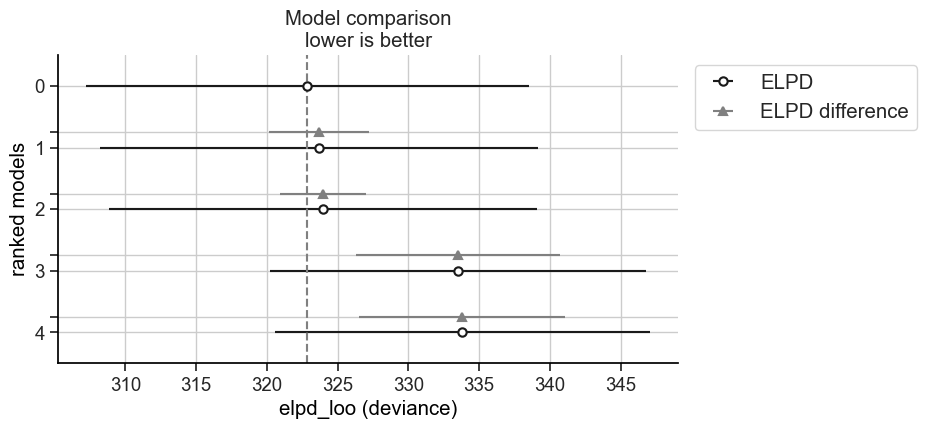

In [81]:
comp_df = az.compare(
    dict(enumerate(fox_traces)),
    ic="loo",
    seed=RANDOM_SEED,
    scale="deviance",
)
az.plot_compare(
    comp_df,
    figsize=(8, 4)
);

The order in which the predictor sets are listed is the same as the order of the PSIS values.
Once we take the standard errors into account, it looks like the first three models are essentially identical in PSIS score, and the last two models are the same.

Recall that the DAG for the foxes is:

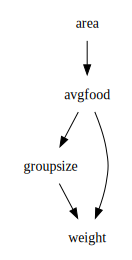

In [83]:
g = gr.Digraph("7h5", node_attr={"color": "white"})

g.node("area")
g.node("avgfood")
g.node("groupsize")
g.node("weight")

g.edge("area", "avgfood")
g.edge("avgfood", "groupsize")
g.edge("avgfood", "weight")
g.edge("groupsize", "weight")
g

The causal effect comes from `area`, via `avgfood`, so any model with either `area` and/or `avgfood` should be able to capture the total causal effect and so predict `weight` well.
But, the effect is mediated through `groupsize` and so we should expect that a model that includes `groupsize` as a predictor should reduce variance in the outcome and so lead to a better predictive model.
We can see that in the PSIS scores: the three models that include `groupsize` have better (pretty indistinguishible) PSIS compared with the models that don't include it.

We can see how the parameter estimates change between the different models:

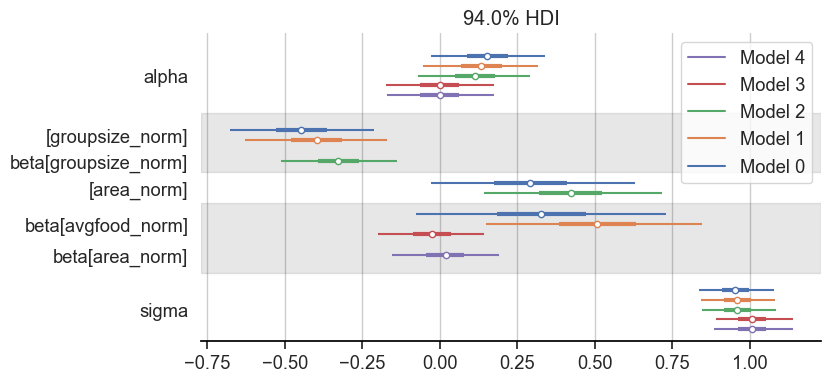

In [85]:
az.plot_forest(
    fox_traces,
    var_names=["~mu"],
    combined=True,
    figsize=(8, 4)
);